<a href="https://colab.research.google.com/github/Krishnakanth1993/TASAI_ERA/blob/main/MNIST_Model/Notebooks/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


# **Understanding the Data**

In [ ]:
# Load MNIST training data without normalization
train_data = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=512, shuffle=False)

# Compute mean and std
mean = 0.0
std = 0.0
total_images = 0

for images, _ in train_loader:
    batch_samples = images.size(0)  # Number of images in batch
    images = images.view(batch_samples, -1)  # Flatten: [batch_size, 1, 28, 28] -> [batch_size, 784]
    mean += images.mean(dim=1).sum().item()  # Sum mean across pixels for each image
    std += images.std(dim=1).sum().item()  # Sum std across pixels for each image
    total_images += batch_samples

mean /= total_images
std /= total_images

print(f'Mean: {mean:.4f}, Std: {std:.4f} ,Total_images: {total_images}')

Mean: 0.1307, Std: 0.3015 ,Total_images: 60000


In [ ]:
dataloader_iterator = iter(train_loader)
batch_data = next(dataloader_iterator)

for item in batch_data:
  if isinstance(item, torch.Tensor):
      #print(item)
      print(f"Shape of a tensor in the batch: {item.shape}")
  else:
      #print(item)
      print(f"Type of item in batch: {type(item)}")

Shape of a tensor in the batch: torch.Size([512, 1, 28, 28])
Shape of a tensor in the batch: torch.Size([512])


# **Data Loading & Preprocessing**

In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1407,), (0.4081,)) # Mean: 0.1307, Std: 0.3015 ,Total_images: 60000 . Normalization must be uniform between train and test.
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


In [5]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

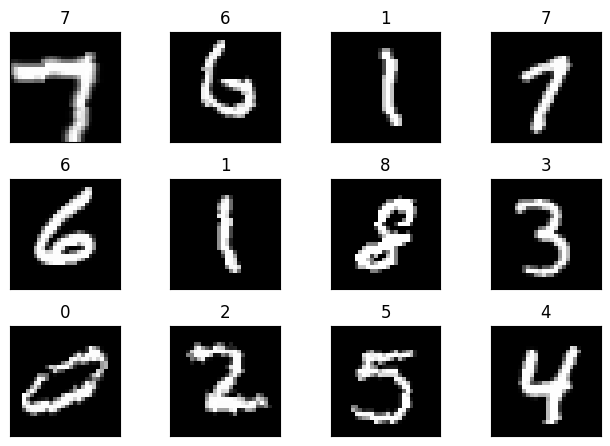

In [6]:
batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

# **Model Architecture**

In [19]:
  class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3) #28x28x1  | (3x3x1)16 | 26x26x16 RF 3x3
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3) #26x26x16 | (3x3x16)x32 | 24x24x32 RF 5x5
        self.conv3 = nn.Conv2d(32, 40, kernel_size=3) #12x12x32 | (3x3x32)x40 | 10x10x40 RF 12x12
        self.conv4 = nn.Conv2d(40, 24, kernel_size=1) #5x5x40 | (1x1x40)x24 | 5x5x24 RF 24x24
        self.fc1 = nn.Linear(24 * 5 * 5, 10) #RF 24x24

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv4(x))
        x = x.view(-1, 24 * 5 * 5)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

# Training Setup

In [14]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [15]:
# Define GetCorrectPredCount
def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

# Training function
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = criterion(pred, target)  # Shape: [batch_size]
        train_loss += loss.sum().item()  # Sum per-sample losses for reporting
        loss = loss.mean()  # Average for backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc=f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader.dataset))  # Average per sample

# Test function
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)  # Shape: [batch_size]
            test_loss += loss.sum().item()  # Sum per-sample losses
            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)  # Average per sample
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [20]:
# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
num_epoch = 20
# Training loop for 10 epochs
for epoch in range(1, num_epoch+1):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, criterion)
    test(model, device, test_loader, criterion)
    scheduler.step()

Epoch 1


Train: Loss=0.1252 Batch_id=117 Accuracy=81.11: 100%|██████████| 118/118 [00:17<00:00,  6.68it/s]


Test set: Average loss: 0.1055, Accuracy: 9676/10000 (96.76%)

Epoch 2


Train: Loss=0.1072 Batch_id=117 Accuracy=96.09: 100%|██████████| 118/118 [00:18<00:00,  6.33it/s]


Test set: Average loss: 0.0661, Accuracy: 9782/10000 (97.82%)

Epoch 3


Train: Loss=0.1214 Batch_id=117 Accuracy=96.99: 100%|██████████| 118/118 [00:17<00:00,  6.64it/s]


Test set: Average loss: 0.0578, Accuracy: 9814/10000 (98.14%)

Epoch 4


Train: Loss=0.1872 Batch_id=117 Accuracy=97.05: 100%|██████████| 118/118 [00:20<00:00,  5.73it/s]


Test set: Average loss: 0.0567, Accuracy: 9821/10000 (98.21%)

Epoch 5


Train: Loss=0.0654 Batch_id=117 Accuracy=97.13: 100%|██████████| 118/118 [00:18<00:00,  6.38it/s]


Test set: Average loss: 0.0554, Accuracy: 9827/10000 (98.27%)

Epoch 6


Train: Loss=0.0842 Batch_id=117 Accuracy=97.13: 100%|██████████| 118/118 [00:17<00:00,  6.74it/s]


Test set: Average loss: 0.0549, Accuracy: 9830/10000 (98.30%)

Epoch 7


Train: Loss=0.1021 Batch_id=117 Accuracy=97.14: 100%|██████████| 118/118 [00:20<00:00,  5.72it/s]


Test set: Average loss: 0.0548, Accuracy: 9829/10000 (98.29%)

Epoch 8


Train: Loss=0.0379 Batch_id=117 Accuracy=97.24: 100%|██████████| 118/118 [00:19<00:00,  6.02it/s]


Test set: Average loss: 0.0548, Accuracy: 9829/10000 (98.29%)

Epoch 9


Train: Loss=0.1448 Batch_id=117 Accuracy=97.16: 100%|██████████| 118/118 [00:17<00:00,  6.80it/s]


Test set: Average loss: 0.0548, Accuracy: 9829/10000 (98.29%)

Epoch 10


Train: Loss=0.0589 Batch_id=117 Accuracy=97.13: 100%|██████████| 118/118 [00:18<00:00,  6.40it/s]


Test set: Average loss: 0.0548, Accuracy: 9829/10000 (98.29%)

Epoch 11


Train: Loss=0.0887 Batch_id=117 Accuracy=97.15: 100%|██████████| 118/118 [00:17<00:00,  6.83it/s]


Test set: Average loss: 0.0548, Accuracy: 9829/10000 (98.29%)

Epoch 12


Train: Loss=0.0881 Batch_id=117 Accuracy=97.21: 100%|██████████| 118/118 [00:18<00:00,  6.46it/s]


Test set: Average loss: 0.0548, Accuracy: 9829/10000 (98.29%)

Epoch 13


Train: Loss=0.1006 Batch_id=117 Accuracy=97.23: 100%|██████████| 118/118 [00:18<00:00,  6.55it/s]


Test set: Average loss: 0.0548, Accuracy: 9829/10000 (98.29%)

Epoch 14


Train: Loss=0.0623 Batch_id=117 Accuracy=97.20: 100%|██████████| 118/118 [00:17<00:00,  6.73it/s]


Test set: Average loss: 0.0548, Accuracy: 9829/10000 (98.29%)

Epoch 15


Train: Loss=0.0623 Batch_id=117 Accuracy=97.19: 100%|██████████| 118/118 [00:18<00:00,  6.24it/s]


Test set: Average loss: 0.0548, Accuracy: 9829/10000 (98.29%)

Epoch 16


Train: Loss=0.0803 Batch_id=117 Accuracy=97.06: 100%|██████████| 118/118 [00:17<00:00,  6.65it/s]


Test set: Average loss: 0.0548, Accuracy: 9829/10000 (98.29%)

Epoch 17


Train: Loss=0.1915 Batch_id=117 Accuracy=97.17: 100%|██████████| 118/118 [00:18<00:00,  6.30it/s]


Test set: Average loss: 0.0548, Accuracy: 9829/10000 (98.29%)

Epoch 18


Train: Loss=0.1378 Batch_id=117 Accuracy=97.25: 100%|██████████| 118/118 [00:17<00:00,  6.69it/s]


Test set: Average loss: 0.0548, Accuracy: 9829/10000 (98.29%)

Epoch 19


Train: Loss=0.1487 Batch_id=117 Accuracy=97.15: 100%|██████████| 118/118 [00:18<00:00,  6.44it/s]


Test set: Average loss: 0.0548, Accuracy: 9829/10000 (98.29%)

Epoch 20


Train: Loss=0.1891 Batch_id=117 Accuracy=97.20: 100%|██████████| 118/118 [00:17<00:00,  6.75it/s]


Test set: Average loss: 0.0548, Accuracy: 9829/10000 (98.29%)



# Test Results

Text(0.5, 1.0, 'Test Accuracy')

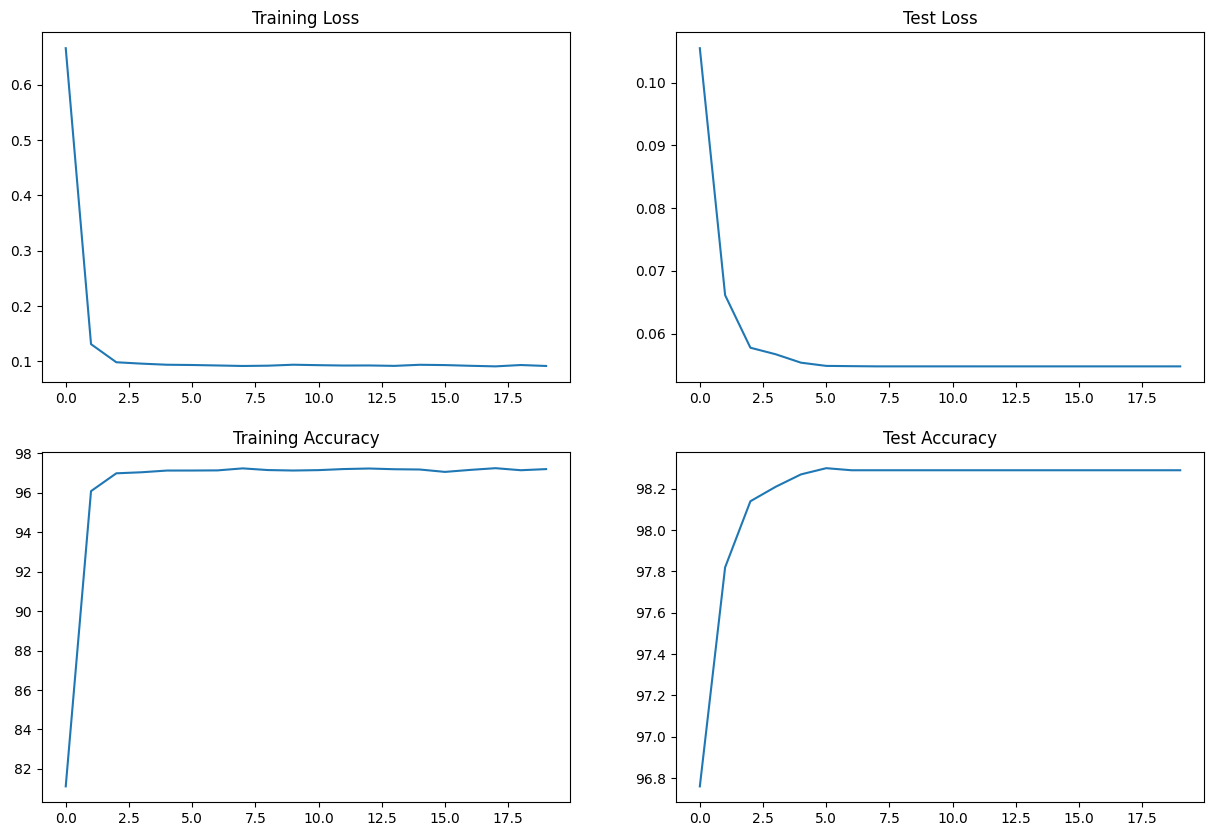

In [30]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [24]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
            Conv2d-2           [-1, 32, 24, 24]           4,640
            Conv2d-3           [-1, 40, 10, 10]          11,560
            Conv2d-4             [-1, 24, 5, 5]             984
            Linear-5                   [-1, 10]           6,010
Total params: 23,354
Trainable params: 23,354
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 0.09
Estimated Total Size (MB): 0.35
----------------------------------------------------------------
